In [1]:
%config InlineBackend.figure_format = 'svg'

(appendix_03)=

# Appendix 3: Uncertainty Propagation

**Uncertainty** occurs in any scientific measurement and is often represented as the standard deviations, $\sigma$, of measurements or the 95% confidence interval, 95% CI. When performing calculations containing values with uncertainty, the uncertainty needs to be propagated through the calculations, which is a tedious and error-prone task when done by hand. This appendix demonstrates how to use the Python `uncertainties` package to remove most of the pain from uncertainty propagation along with simulating uncertainty using a random number generator.

## `Uncertainties` Package

As of this writing, the `uncertainties` package can be [installed using pip](https://uncertainties.readthedocs.io/en/latest/). We will then import a couple key functions, `ufloat()` and `ufloat_fromstr()`, along with the `umath` module which brings a range of math functions (e.g., log and sin). We will also import NumPy and matplotlib to use in the simulation section.

In [2]:
from uncertainties import ufloat, ufloat_fromstr
from uncertainties import umath

import numpy as np
import matplotlib.pyplot as plt

### Uncertainties Variable

Basic mathematical operations with the `uncertainties` package center around the uncertainties variable object. This is created using the `ufloat()` function accepts two important values - the first is the nominal value and the second is the standard deviation.

~~~python
ufloat(nominal_value, std_dev)
~~~

For example, let's say we have a value of 18.66 with a standard deviation of 0.03.

In [3]:
val = ufloat(18.32, 0.03)

We can access the nominal value or the standard deviation by themselves using the `nominal_value` or `std_dev` methods, respectively.

````{margin}
```{tip}
The `nominal_value` or `std_dev` methods also have aliases `n` and `s`, respectively.
```
````

In [4]:
val.nominal_value

18.32

In [5]:
val.std_dev

0.03

### Values from Strings

If you are calculating uncertainties taken from a text problem, the `uncertainties` package provides a convenience function `ufloat_fromstr()` that allows you to copy-and-paste in values and their uncertainties all together. Below are acceptable formats.

In [6]:
ufloat_fromstr('0.011 ± 0.002')

0.011+/-0.002

In [7]:
ufloat_fromstr('0.172807(0.000008)')

0.172807+/-8e-06

In [8]:
ufloat_fromstr('0.172807 +/- 0.000008')

0.172807+/-8e-06

In [9]:
ufloat_fromstr('0.172')

0.172+/-0.001

The last one did not include an uncertainty, so the uncertainty was interpreted to be $\pm$1 of the least significant decimal place.

### Simple Calculations

Beyond this, we just need to carry out our mathematical operations. For example, let's say we want to calculate the molar absorptivity constant using Beer's law, $A = \epsilon bC$, where A is absorbance, $\epsilon$ is the molar absorptivity constant, $b$ is the path length in cm, and $C$ is concentration in molarity. If the A = 0.3822 $\pm$ 0.0003, $b$ = 1.00$\pm$0.01 cm, and $C$=0.0017$\pm$0.0001 M, we can calculate the molar absorptivity constant like below.

In [10]:
A = ufloat(0.3822, 0.0003)
b = ufloat(1.00, 0.01)
C = ufloat(0.0017, 0.0001)

E = A / (b * C)
E

224.8235294117647+/-13.415813085736838

This results in 225$\pm$13 cm$^{-1}$M$^{-1}$.

If we multiply an uncertainties variable object by a regular `int` or `float()`, the `int` or `float()` is treated as having no uncertainty, so the uncertainty of the other value scales linearly with the nominal value. In the example below, both values triple.

In [11]:
3 * b

3.0+/-0.03

The `umath` module provides special mathematical functions like square root or sine. For example, if we want to calculate the pH of a solution with an [H$_3$O$^+$] = 6.33$\times$10$^{-6}$ $\pm$ 3$\times$10$^{-7}$ M, or (6.33 $\pm$ 0.3)$\times$10$^{-6}$ M, we can carry out this calculation below which gives us a pH = 5.199$\pm$0.021.

````{margin}
```{note}
Like in many Python libraries, `log()` is the natural log and `log10()` is the common log.
```
````

In [12]:
H3O = ufloat(6.33e-6, 3e-7)
-umath.log10(H3O)

5.198596289982645+/-0.02058267686745269

### Correlated Values

The above calculations assume that all the values in the calculation have no correlation with each other, which is not always the case. When correlation occurs, this adds an extra layer of complexity to the error propagation calculations. The `uncertainties` package recognizes some correlation automatically and handles it for you such as below when subtracting a value by itself.

In [13]:
b - b

0.0+/-0

If a new value is calculated using `uncertainties`, the package automatically recognizes and factors in the correlation into future calculations. We can get a sense of the correlation using the `covariance_matrix()` or `correlation_matrix()` functions. For example, we can input variables from the above Beer's law problem to see the covariance and correlation matrices.

In [14]:
from uncertainties import covariance_matrix, correlation_matrix

In [15]:
covariance_matrix([b, C, E])

[[0.0001, 0.0, -0.022482352941176467],
 [0.0, 1e-08, -0.0013224913494809688],
 [-0.022482352941176467, -0.0013224913494809688, 179.98404075142776]]

In [16]:
correlation_matrix([b, C, E])

array([[ 1.        ,  0.        , -0.16758099],
       [ 0.        ,  1.        , -0.98577055],
       [-0.16758099, -0.98577055,  1.        ]])

When correlated values are derived outside of `uncertainties` such as in linear regressions, the user needs to provide correlation information when creating uncertainties variable objects. This is done with the `correlated_values()` function which requires the nominal values and a covariance matrix as the two required positional arguments. Alternatively, you can use the related `correlated_values_norm()` function which instead accepts the nominal values and the correlation matrix.

~~~python
correlated_values(nominal_values, covariance_matrix)
correlated_values_norm(nominal_values, correlation_matrix)
~~~

The good news is that NumPy and SciPy functions can also return the covariance matrix along with the best fit parameters. For example, `scipy.optimize.curve_fit()` automatically returns `pcov` which is the "estimated approximate" covariance matrix and `numpy.polyfit(cov=True)` returns the scaled covariance matrix as a second returned item when `cov=True`.

Below, we will demonstrate this using a calibration curve for absorbance and concentration data using the `np.polyfit()` function introduced in [section 6.4.1](6.4.1).

In [17]:
A_data = np.array([0.104, 0.197, 0.361, 0.706, 0.970])
C_data = np.array([1.0e-06, 2.0e-06, 4.0e-06, 8.0e-06, 1.2e-05])

fit, cov = np.polyfit(C_data, A_data, deg=1, cov=True)
fit

array([7.93846154e+04, 3.89230769e-02])

In [18]:
cov

array([[ 6.86575444e+06, -3.70750740e+01],
       [-3.70750740e+01,  3.14451553e-04]])

The fit returns the slope and *y*-intercept values along with the covariance matrix. We can then create our uncertainties variable in `uncertainties` by providing both to the `correlated_values()` function.

In [19]:
from uncertainties import correlated_values

m, b = correlated_values(fit, cov)
m

79384.61538461538+/-2620.258467760363

In [20]:
b

0.03892307692307681+/-0.017732781881431937

If we then decide to calculate the concentration for an absorbance of 0.501, for example, `uncertainties` will factor in uncertainty and correlation automatically like below.

In [21]:
(0.501 - b) / m

5.8207364341085285e-06+/-1.3535749157410873e-07

If we were to carry about the above calculation *without* factoring in correlation, it would look like below. While the value itself does not change, the uncertainty is overestimated.

In [22]:
m_uncorr = ufloat_fromstr('79384.6153846154+/-2620.258467760346')
b_uncorr = ufloat_fromstr('0.038923076923077046+/-0.01773278188143182')

(0.501 - b_uncorr) / m_uncorr

5.820736434108524e-06+/-2.9463551943621185e-07

## Simulating Uncertainties

We can also simulate uncertainties using Monte Carlo simulations as demonstrated below. Let's say we want to calculate the molar absorptivity constant using the same nominal and standard deviation values as above. Using a random number generator, we can generate values for A, $l$, and C with the given standard deviations using the `normal(nominal_value, std_dev)` function from the [`numpy.random` module](4.7). We then carry out the calculation with all of these values. The molar absorptivity is the average of these values with and uncertainty calculated from the standard deviation of these calculated values.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
A_nom, A_sig = 0.3822, 0.0003
l_nom, l_sig = 1.00, 0.01
C_nom, C_sig = 0.0017, 0.0001

N = int(1e7)
rng = np.random.default_rng(seed=21)
A = rng.normal(loc=A_nom, scale=A_sig, size=N)
l = rng.normal(loc=l_nom, scale=l_sig, size=N)
C = rng.normal(loc=C_nom, scale=C_sig, size=N)

E = A / (l * C)

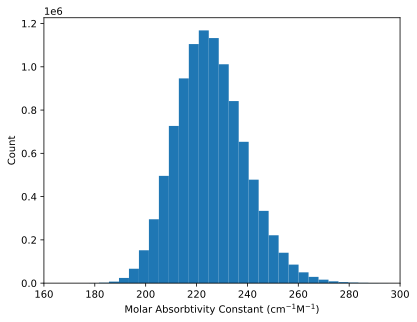

In [25]:
plt.hist(E, bins=40)
plt.xlim(160, 300)
plt.xlabel('Molar Absorbtivity Constant (cm$^{-1}$M$^{-1}$)')
plt.ylabel('Count');

In [26]:
print(np.mean(E))
print(np.std(E, ddof=1))

225.63035520507208
13.600103576801123


This results in a value of 226$\pm$14 cm$^{-1}$M$^{-1}$, which is close to what we calculated using the `uncertainties` library.

## Further Reading

1. Documentation for `uncertainties` package. [https://uncertainties.readthedocs.io/en/latest/](https://uncertainties.readthedocs.io/en/latest/) (free resource)
   
2. NumPy `polyfit()` Documentation. [https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) (free resource)

3. SciPy `curve_fit()` Documentation. [https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) (free resource)

4. Salter, C. Error Analysis Using the Variance-Covariance Matrix. *J. Chem. Educ.* **2000,** 77 (9), 1239. [https://doi.org/10.1021/ed077p1239](https://doi.org/10.1021/ed077p1239).

   >Provides background and an example of using a variance-covariance matrix.